In [1]:
from os import path
import pandas as pd
import seaborn as sns; sns.set()
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.vq import vq, kmeans
from matplotlib.patches import Patch, Ellipse
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark-palette')

In [2]:
# Importing data
df = pd.read_csv("../data/tables/metadata_table.csv", sep=";")
# Converting GC to %
df["GC"] = df["GC"].apply(lambda n: n * 100)

In [3]:
df["Proposed Name"] = df["New_Genus"] + " " + df["New_Species"] + " " + df["Strain"]

In [4]:
# # Generating Table_S1. Uncomment if you want to overwrite.
# df[[
#     "organism_name",
#     "New_Genus",
#     "New_Species",
#     "Strain",
#     "assembly_accession",
#     "bioproject",
#     "biosample",
#     "Completeness",
#     "Contamination",
#     "submitter",
#     "seq_rel_date",
#     "Size",
#     "GC"
# ]].to_csv("../data/tables/Table_S1.csv", index=False)

In [5]:
# Adding column of number of genomes per genus and species
df["No_genus"] = df.groupby('New_Genus')['New_Genus'].transform('count').map(int, na_action="ignore")
df["No_species"] = df.groupby('New_Species')['New_Species'].transform('count').map(int, na_action="ignore")

# Adding a formatted name to use in your legends
df["name_fmt"] = df["New_Genus"] + " ("+ df["No_genus"].map(int, na_action="ignore").map(str) + ")"
df["name_fmt"] = df["name_fmt"].apply(lambda s: s.replace(".0", "") if type(s) == str else s)

In [6]:
def raw(str):
    return r'${}$'.format(str)

In [7]:
df["name_fmt2"] = df["name_fmt"].apply(lambda s: str(s).replace("Synechospongium", "Synechospongium\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: str(s).replace("Lacustricoccus", "Lacustricoccus\ \mathrm{gen. nov.}"))
df["name_fmt2"] = df["name_fmt2"].apply(lambda s: raw(str(s).replace(" (", "\ (")))

In [8]:
# Applying QC
df = df.query("Completeness >= 50 & Contamination <= 10 & No_genus > 1")

In [9]:
color_dict = {
    "$Parasynechococcus\ (47)$": "royalblue",  # blue
    "$Pseudosynechococcus\ (41)$": "royalblue",
    "$Synechospongium\ \mathrm{gen. nov.}\ (28)$": "seagreen",  # green
    "$Enugrolinea\ (12)$":"mediumpurple",  # purple
    "$Regnicoccus\ (9)$":"darkturquoise",  # cyan
    "$Inmanicoccus\ (8)$":"darkturquoise",
    "$Leptococcus\ (8)$":"mediumpurple",
    "$Thermosynechococcus\ (6)$":"mediumpurple",
    "$Synechococcus\ (5)$":"mediumpurple",
    "$Magnicoccus\ (3)$":"darkturquoise",
    "$Lacustricoccus\ \mathrm{gen. nov.}\ (3)$":"darkturquoise"
}

df["color"] = df["name_fmt2"].apply(lambda s: color_dict[s])

Text(0, 0.5, '')

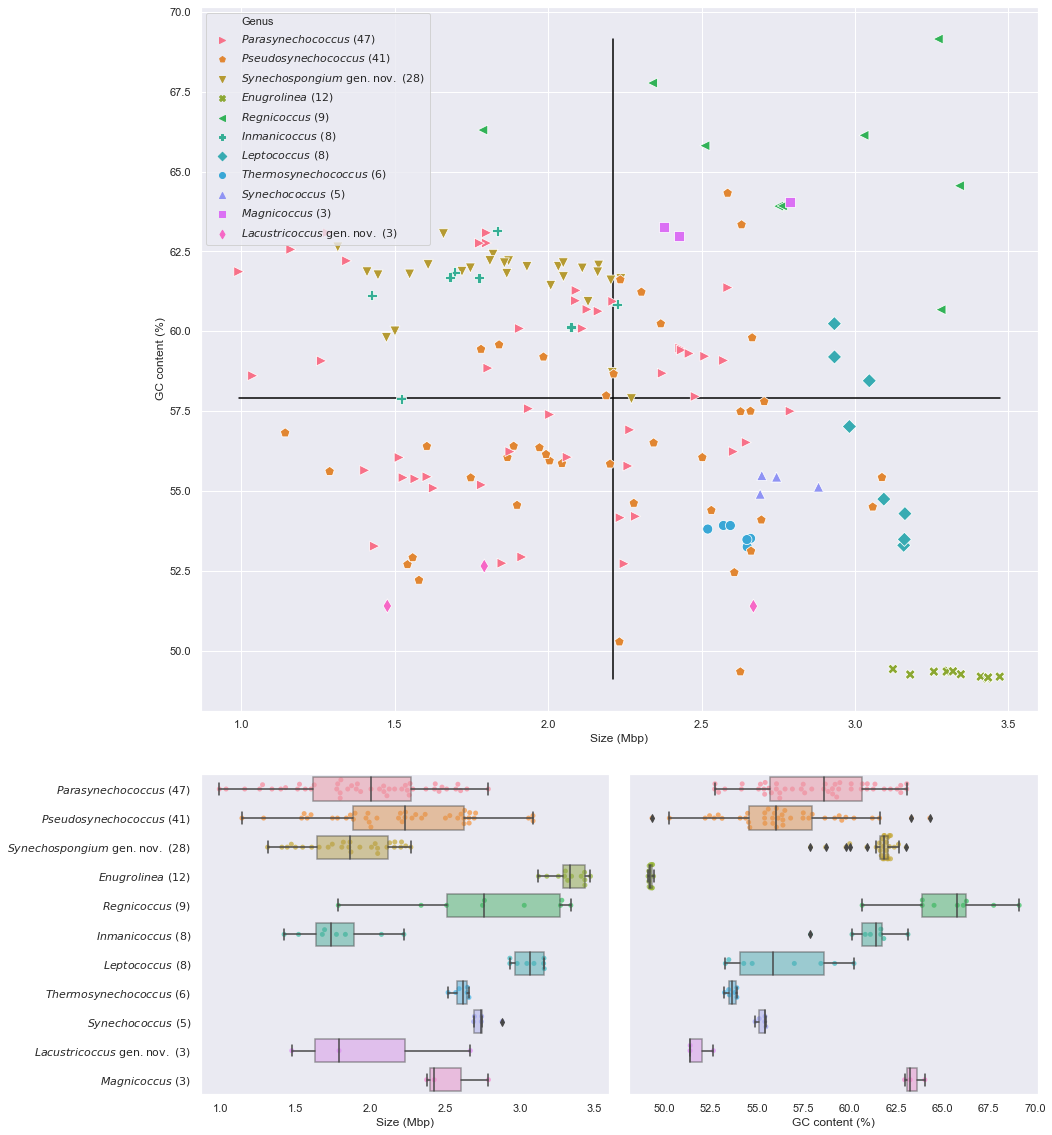

In [10]:
# Large plot
fig = plt.figure(figsize=(15, 20))

gs = GridSpec(
    nrows=3, ncols=2, height_ratios=[1,1,1], wspace=0.05
)

max_s, min_s, median_s = max_s, min_s, median_s = df["Size"].max(), df["Size"].min(), df["Size"].median()
max_gc, min_gc, median_gc = df["GC"].max(), df["GC"].min(), df["GC"].median()
order = list(df["name_fmt2"].value_counts().index)
filled_markers = ('o', 'v', '^', '<', 'p', '>', 's', 'D', 'd', 'P', 'X', )

# Scatter plot
ax0 = fig.add_subplot(gs[:2, :])
ax0.plot([max_s, min_s], [median_gc, median_gc], color="black", zorder=1)
ax0.plot([median_s, median_s], [max_gc, min_gc], color="black", zorder=1)
sns.scatterplot(
            x="Size",
            y="GC",
            data=df.sort_values(
                by="No_genus", ascending=False
            ),
            hue=df["name_fmt2"],
            style=df["name_fmt2"],
            # palette=color_dict,
            hue_order=order,
            s=100,
            zorder=2,
            markers=filled_markers,
            ax=ax0,
        )
legend = ax0.legend()
legend.texts[0].set_text("Genus")

# Size plot
ax1 = fig.add_subplot(gs[2, 0])
sns.boxplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax1)
sns.swarmplot(
    y="name_fmt2",
    x="Size",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
        hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax1)

# GC plot
ax2 = fig.add_subplot(gs[2, 1], sharey=ax1)
sns.boxplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False
    ),
    boxprops=dict(alpha=.5),
    ax=ax2)
sns.swarmplot(
    y="name_fmt2",
    x="GC",
    data=df.sort_values(
        by="No_genus", ascending=False)
    ,
    hue="name_fmt2",
    alpha=0.7,
    zorder=0,
    ax=ax2)


# Hiding legends
plt.setp(ax2.get_yticklabels(), visible=False)
ax1.legend().remove()
ax2.legend().remove()
ax1.grid(False)
ax2.grid(False)

# Fixing labels
ax0.set_xlabel("Size (Mbp)")
ax0.set_ylabel("GC content (%)")
ax1.set_xlabel("Size (Mbp)")
ax1.set_ylabel("")
ax2.set_xlabel("GC content (%)")
ax2.set_ylabel("")

# plt.savefig("../data/plots/Figure_1_concat.png", dpi=700, bbox_inches="tight",)


In [37]:
# Basis for Table 1
df.groupby("New_Genus").describe().round(2)[["Size", "GC"]][
    [
        ("Size", "mean"),
        ("Size", "std"),
        ("GC", "mean"),
        ("GC", "std"),
        ("Size", "count"),
    ]
].sort_values(("Size", "count"), ascending=False).to_csv("../data/tables/Table_1.csv", header=None)

In [43]:
# Formatting Table 1
table_1 = pd.read_csv("../data/tables/Table_1.csv")
table_1.columns=(
    "Genus,Size mean (Mb),Size std,GC % mean,GC % std,# genomes".split(
        ','))

In [44]:
table_values = {
    "Parasynechococcus": [],
    "Pseudosynechococcus": [],
    "Synechospongium": [],
    "Enugrolinea": [],
    "Regnicoccus": [],
    "Inmanicoccus": [],
    "Leptococcus": [],
    "Thermosynechococcus": [],
    "Synechococcus": [],
    "Lacustricoccus": [],
    "Magnicoccus": []
}

In [45]:
# Choose type species based on completeness and release date
for k, v in table_values.items():
    table_values[k].append(df[
        (df["New_Genus"] == k) &
        (df["TypeSpecies"] == "yes")
      ][["Proposed Name", "Completeness", "seq_rel_date"]])

In [46]:
table_values = {
    "Parasynechococcus": [
        "Parasynechococcus africanus CC9605",
        "Synechococcus sp.",
        "Marine (oceanic)",
        22,
    ],
    "Pseudosynechococcus": [
        "Pseudosynechococcus subtropicalis WH 7805",
        "Synechococcus sp.",
        "Marine (oceanic)",
        21,
    ],
    "Synechospongium": [
        "Synechospongium spongiarum 15L",
        "Candidatus Synechococcus spongiarum",
        "Symbiont",
        7,
    ],
    "Enugrolinea": [
        "Enugrolinea euryhalinus PCC 7002",
        "Synechococcus sp.",
        "Freshwater",
        3,
    ],
    "Regnicoccus": [
        "Regnicoccus antarcticus WH 5701",
        "Synechococcus sp.",
        "Marine (coastal)",
        7,
    ],
    "Inmanicoccus": [
        "Inmanicoccus mediterranei RCC307",
        "Synechococcus sp.",
        "Marine (coastal)",
        5,
    ],
    "Leptococcus": [
        "Leptococcus yellowstonii JA-3-3Ab",
        "Synechococcus sp.",
        "Thermophilic",
        2,
    ],
    "Thermosynechococcus": [
        "Thermosynechococcus vulcanus NIES-2134",
        "Thermosynechococcus vulcanus",
        "Thermophilic",
        5,
    ],
    "Synechococcus": [
        "Synechococcus elongatus PCC 6301",
        "Synechococcus elongatus",
        "Freshwater",
        2,
    ],
    "Lacustricoccus": [
        "Lacustricoccus lacustris TousA",
        "Synechococcus lacustris",
        "Brackish",
        2,
    ],
    "Magnicoccus": [
        "Magnicoccus sudiatlanticus CB0101",
        "Synechococcus sp.",
        "Marine (coastal)",
        2,
    ]
}

In [16]:
table_1["Type Genome"] = table_1["Genus"].apply(lambda s: table_values[s][0])
table_1["NCBI name"] = table_1["Genus"].apply(lambda s: table_values[s][1])
table_1["Lifestyle"] = table_1["Genus"].apply(lambda s: table_values[s][2])
table_1["# species*"] = table_1["Genus"].apply(lambda s: table_values[s][3])

table_1["GC content (%)"] = table_1.apply(lambda row:
                                          f"{row['GC % mean']} ± {row['GC % std']}",
                                          axis=1
                                         )
table_1["Genome size (Mbps)"] = table_1.apply(lambda row:
                                          f"{row['Size mean (Mb)']} ± {row['Size std']}",
                                          axis=1
                                         )

KeyError: 'Genus'

In [ ]:
table_1[[
    "Genus",
    "# genomes",
    "# species*",
    "Type Genome",
    "NCBI name",
    "Lifestyle",
    "GC content (%)",
    "Genome size (Mbps)"
]].set_index("Genus").to_csv("../data/tables/Table_1.csv")

In [ ]:
# # Creating GToTree input - uncomment if you wish to generate it.
# df["proteins_file"].to_csv("../data/gtt/gtt_input.csv", index=False, header=False)
# df["proteins_file_fmt"] = df["proteins_file"].apply(lambda s: path.basename(s))
# df[["proteins_file_fmt", "Proposed Name"]].to_csv("../data/gtt/gtt_labels.tsv", index=False, header=False, sep="\t")

# # Add Prochlorococcus marinus to root the tree (GCA_000007925.1)
# !echo "/home/vini/data/prosyn/processing/prodigal/proteins/GCA_000007925.1_ASM792v1_genomic_prodigal_proteins.faa" >> ../data/gtt/gtt_input.csv
# !echo "GCA_000007925.1_ASM792v1_genomic_prodigal_proteins.faa\tProchlorococcus marinus CCMP1375" >> ../data/gtt/gtt_labels.tsv